# Reinforcement learning
- multi armed bandit 1 https://towardsdatascience.com/solving-the-multi-armed-bandit-problem-b72de40db97c
- multi armed bandit 2 https://medium.com/@SYM0920/the-multi-armed-bandits-problem-bba9ea35a1e4
- thompson sampling https://arxiv.org/pdf/1707.02038.pdf
- upper confidence boundshttp://banditalgs.com/2016/09/18/the-upper-confidence-bound-algorithm/
- exploration vs exploitation tradeoff https://medium.com/@dennybritz/exploration-vs-exploitation-f46af4cf62fe
- regret https://stats.stackexchange.com/questions/171850/why-regret-is-used-in-online-machine-learning-and-is-there-any-intuitive-explana

#### Upper confidence bound
- assumes a starting value for each distribution
- randomly test a distribution (explore)
- decrease or increase the confidence bound for that distribution based off the observation
- shrink the confidence bound
- repeat 2 through 4 n number of times
- exploit the distribution with the highest bound

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

### Get the dataset
- data set of online ads
- ctr = click through rate, find ad that gives most clicks

In [16]:
df = pd.read_csv("Ads_CTR_Optimisation.csv")
rows = len(df)
cols = len(df.keys())
print(rows)
print(cols)
df.head()

10000
10


,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


- cols = different versions of the same ad (i.e. 10 "armed bandits")
- rows = number of users shown a version of the ad
- 1 indicates a user clicks on the ad, 0 else

### view the performance of random selection

In [36]:
ads = []
reward = 0
for i in range(0, len(df)):
    j = random.randrange(len(df.keys()))
    ads.append(j)
    reward = reward + df.values[i, j]

- visualize the performance

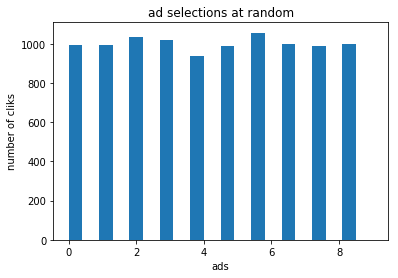

total reward:  1211


In [37]:
plt.hist(ads, width=.4)
plt.title("ad selections at random")
plt.xlabel("ads")
plt.ylabel("number of cliks")
plt.show()
print("total reward: ", reward)

### Implement UCB
- deterministic
- initialize arrays for the times an ad was selected and the total reward for that ad

In [32]:
selected = []
selections = np.zeros(cols)
rewards = np.zeros(cols)
totalReward = 0

- first sample each distribution at least once
- compute average reward of ad j up to round i
- compute delta j (confidence measure)
- compute the confidence interval of ad j at round i
- add the selected ad to the selected array, update the current and total rewards

In [33]:
for i in range(0, rows):
    maxUCB = 0
    ad = 0
    for j in range(0, cols): 
        if(selections[j] > 0): #executes after first round
            avgReward = rewards[j] / selections[j]
            delta_j = math.sqrt(3/2 * math.log(i+1) / selections[j])
            ucb = avgReward + delta_j
        else:
            ucb = float('inf')
        if(ucb > maxUCB):
            maxUCB = ucb
            ad = j
    selected.append(ad)
    np.add.at(selections, ad, 1) #increment by 1
    curReward = df.values[i, ad]#get the reward (whether they clicked or not) of the current ad
    np.add.at(rewards, ad, curReward) #increment the rewards by the reward amount
    totalReward = totalReward + curReward
    

### Visualize the results for UCB

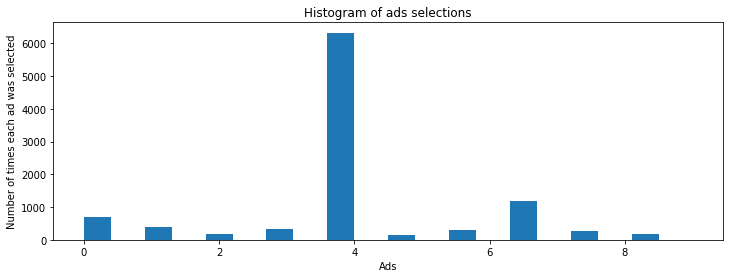

In [64]:
plt.figure(figsize=(12,4))
plt.hist(selected, width=.4)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

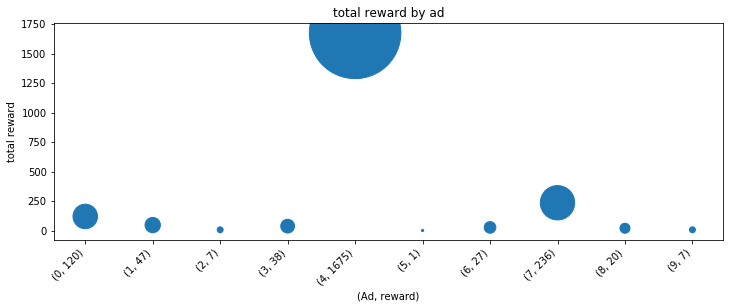

total reward:  2178


In [89]:
size = [x*5 for x in rewards]
plt.figure(figsize=(12,4))
plt.scatter(np.arange(0, len(rewards)), rewards, s=size)
plt.title('total reward by ad')
plt.xlabel('(Ad, reward)')
plt.xticks(np.arange(0, len(rewards)), zip(np.arange(0, len(rewards)), [int(x) for x in rewards]), ha='right', rotation=45)
plt.ylabel('total reward')
plt.show()
print("total reward: ", totalReward)

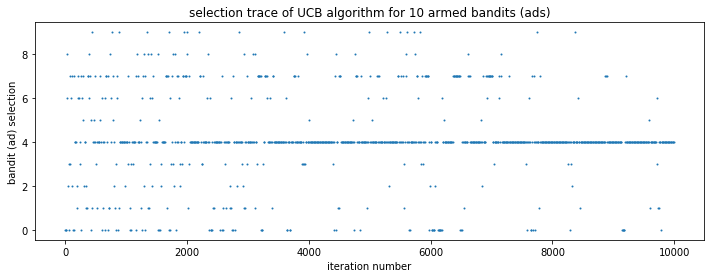

In [57]:
factor = 10
displayed = []
count = np.arange(0, rows)
for i in range(0, rows):
    if(i % factor == 0):
        displayed.append(selected[i])
    else:
        displayed.append(None)

plt.figure(figsize=(12, 4))
plt.scatter(count, displayed, s=1)
plt.title("selection trace of UCB algorithm for 10 armed bandits (ads)")
plt.xlabel("iteration number")
plt.ylabel("bandit (ad) selection")
plt.show()

### Implement Thompson Sampling
- probabilistic
- http://proceedings.mlr.press/v23/agrawal12/agrawal12.pdf
- https://stats.stackexchange.com/questions/187059/what-is-thompson-sampling-in-laymans-terms
- uses the beta distribution (distribution of probabilities) https://stats.stackexchange.com/questions/47771/what-is-the-intuition-behind-beta-distribution
- beta distribution is a conjugate prior https://en.wikipedia.org/wiki/Conjugate_prior#Example
- sample each distribution
- construct meta-distributions of each 
- sample from the meta-distribution
- sample from the distribution with the highest meta-distribution sample
- update the meta-distribution with the previously sampled point
- go back to step 3

In [95]:
# initialize vectors for thompson sampling
numRewardOnes = np.zeros(cols)
numRewardZeros = np.zeros(cols)
selected = []
totalReward = 0

In [96]:
for i in range(0, rows):
    maxRand = 0
    ad = 0
    for j in range(0, cols): 
        randBeta = random.betavariate(numRewardOnes[j]+1, numRewardZeros[j]+1) #sample the meta-distribution
        if(randBeta > maxRand):
            maxRand = randBeta
            ad = j
    selected.append(ad)
    curReward = df.values[i, ad]#get the reward (whether they clicked or not) of the current ad
    if(curReward == 1):
        np.add.at(numRewardOnes, ad, 1)
    else:
        np.add.at(numRewardZeros, ad, 1)
    totalReward = totalReward + curReward

### Visualize the results for Thompson Sampling

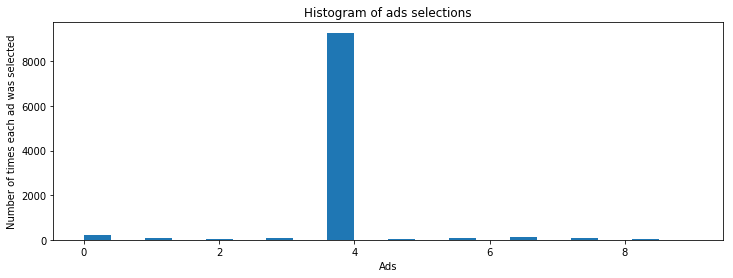

In [97]:
plt.figure(figsize=(12,4))
plt.hist(selected, width=.4)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

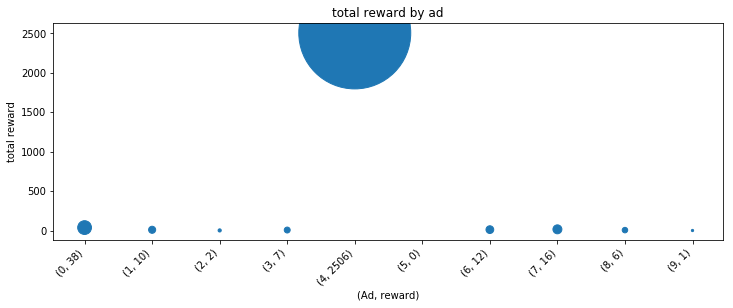

total reward:  2598


In [99]:
rewards = numRewardOnes
size = [x*5 for x in rewards]
plt.figure(figsize=(12,4))
plt.scatter(np.arange(0, len(rewards)), rewards, s=size)
plt.title('total reward by ad')
plt.xlabel('(Ad, reward)')
plt.xticks(np.arange(0, len(rewards)), zip(np.arange(0, len(rewards)), [int(x) for x in rewards]), ha='right', rotation=45)
plt.ylabel('total reward')
plt.show()
print("total reward: ", totalReward)

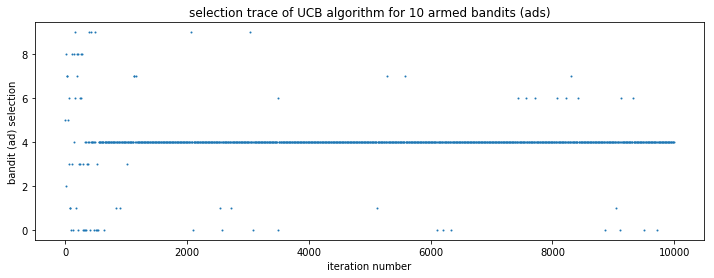

In [100]:
factor = 10
displayed = []
count = np.arange(0, rows)
for i in range(0, rows):
    if(i % factor == 0):
        displayed.append(selected[i])
    else:
        displayed.append(None)

plt.figure(figsize=(12, 4))
plt.scatter(count, displayed, s=1)
plt.title("selection trace of UCB algorithm for 10 armed bandits (ads)")
plt.xlabel("iteration number")
plt.ylabel("bandit (ad) selection")
plt.show()